In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import itertools
import random
from scipy import stats

In [109]:
## Subset both the taxonomy dataframes.
nodeTax = pd.read_csv('../data/notebooks_out/viral_df_taxonomy.csv',index_col=0)

# A few rules for subsetting.

# Has to have family assigned at least
nodeTax = nodeTax[nodeTax['family'] != 'Unclassified']
# Has to fall in a 'insect infecting-like family'.
insectVirFam = ['Parvoviridae','Dicistroviridae','Rhabdoviridae',
               'Iflaviridae','Iridoviridae','Orthomyxoviridae','Nodaviridae','Phenuiviridae','Astroviridae']
nodeTax = nodeTax[nodeTax['family'].isin(insectVirFam)]

sraTax = pd.read_csv('../data/notebooks_out/viral_df_taxonomy_SRA.csv',index_col=0)
sraTax = sraTax[sraTax['family'] != 'Unclassified']
sraTax = sraTax[sraTax['family'].isin(insectVirFam)]

#BackgroundSet
nodeTax = pd.read_csv('../data/notebooks_out/viral_df_taxonomy.csv',index_col=0)
nodeTax = nodeTax[nodeTax['family'] != 'Unclassified']
# Has to fall in a 'insect infecting-like family'.
nodeTax_env = nodeTax[~nodeTax['family'].isin(insectVirFam)]

sraTax_env = pd.read_csv('../data/notebooks_out/viral_df_taxonomy_SRA.csv',index_col=0)
sraTax_env = sraTax_env[sraTax_env['family'] != 'Unclassified']
sraTax_env = sraTax_env[~sraTax_env['family'].isin(insectVirFam)]

In [110]:
#Read in coverage matrix.
covmatsra = pd.read_csv("../data/Pcoa/SRA_df_coverage_lengthnorm.tsv", sep=',', index_col=0)
covmatbe = pd.read_csv("../data/Pcoa/flembee_df_coverage_lengthnorm.tsv", sep=",", index_col=0)
covmatbe = covmatbe.T
covmat = pd.concat([covmatsra, covmatbe], axis=0, join='outer')
# Define covmats, one 'full' to be used as background, one subsetted for the abovementioned families.
covmat_plant = covmat[covmat.columns.intersection(list(sraTax_plant.index) + list(nodeTax_plant.index))]
covmat_insect = covmat[covmat.columns.intersection(list(sraTax.index) + list(nodeTax.index))]

In [111]:
#Now we need information on the eukaryotic family of the host to begin with. For now we keep the flemish bee samples as seperate from apidae.
metadatdf = pd.read_csv("../data/Metadata_location_year_study_kind.csv", sep=";")
list(metadatdf[metadatdf['Tax_family'] == 'Formicidae']['Run'])

#We will only seperate families where we have more than 10 samples each, the others will be collapsed in an 'other'group.
#To start we just take the contig representatives.
Belgium_runs = list(covmatbe.index)
Formicidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Formicidae']['Run'])
Apidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Apidae']['Run'])
Vespidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Vespidae']['Run'])
Halictidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Halictidae']['Run'])
Braconidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Braconidae']['Run'])
Megachilidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Megachilidae']['Run'])
Pteromalidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Pteromalidae']['Run'])
Cephidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Cephidae']['Run'])
Figitidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Figitidae']['Run'])
Gathered = Belgium_runs + Formicidae_runs + Apidae_runs + Vespidae_runs + Halictidae_runs + Braconidae_runs + Megachilidae_runs + Pteromalidae_runs + Cephidae_runs + Figitidae_runs
Others_runs = []
for i in list(metadatdf['Run']):
    if i not in Gathered:
        Others_runs.append(i)

In [112]:
#Sanity test to see if we didn't miss anything:

len(covmat_plant) == len(Belgium_runs) +len(Formicidae_runs) + len(Apidae_runs) + len(Vespidae_runs) + len(Halictidae_runs) + len(Braconidae_runs) + len(Megachilidae_runs) + len(Pteromalidae_runs) + len(Cephidae_runs) + len(Figitidae_runs) + len(Others_runs)


True

In [113]:
# Sanity test to see if insect is full as well
len(covmat_insect) == len(Belgium_runs) +len(Formicidae_runs) + len(Apidae_runs) + len(Vespidae_runs) + len(Halictidae_runs) + len(Braconidae_runs) + len(Megachilidae_runs) + len(Pteromalidae_runs) + len(Cephidae_runs) + len(Figitidae_runs) + len(Others_runs)

True

In [114]:
#Now subset the coverage matrix, so we have 1 matrix / eukaryotic family.
def submat(mat, runCond):
    return mat[mat.index.isin(runCond)]

# Insect specific:
Belgium_insectcov = submat(covmat_insect, Belgium_runs) 
Formicidae_insectcov = submat(covmat_insect, Formicidae_runs) 
Apidae_insectcov = submat(covmat_insect, Apidae_runs) 
Vespidae_insectcov = submat(covmat_insect, Vespidae_runs) 
Halictidae_insectcov = submat(covmat_insect, Halictidae_runs) 
Braconidae_insectcov = submat(covmat_insect, Braconidae_runs) 
Megachilidae_insectcov = submat(covmat_insect, Megachilidae_runs) 
Pteromalidae_insectcov = submat(covmat_insect, Pteromalidae_runs) 
Cephidae_insectcov = submat(covmat_insect, Cephidae_runs) 
Figitidae_insectcov = submat(covmat_insect, Figitidae_runs) 
Others_insectcov = submat(covmat_insect, Others_runs) 

InsectSpecCov = [Belgium_insectcov, Formicidae_insectcov,Apidae_insectcov, Vespidae_insectcov, Halictidae_insectcov,
                 Braconidae_insectcov, Megachilidae_insectcov, Pteromalidae_insectcov, Cephidae_insectcov,
                 Figitidae_insectcov, Others_insectcov
                ]
# Full:
Belgium_plantcov = submat(covmat_plant, Belgium_runs) 
Formicidae_plantcov = submat(covmat_plant, Formicidae_runs) 
Apidae_plantcov = submat(covmat_plant, Apidae_runs) 
Vespidae_plantcov = submat(covmat_plant, Vespidae_runs) 
Halictidae_plantcov = submat(covmat_plant, Halictidae_runs) 
Braconidae_plantcov = submat(covmat_plant, Braconidae_runs) 
Megachilidae_plantcov = submat(covmat_plant, Megachilidae_runs) 
Pteromalidae_plantcov = submat(covmat_plant, Pteromalidae_runs) 
Cephidae_plantcov = submat(covmat_plant, Cephidae_runs) 
Figitidae_plantcov = submat(covmat_plant, Figitidae_runs) 
Others_plantcov = submat(covmat_plant, Others_runs)

FullCov = [Belgium_plantcov, Formicidae_plantcov,Apidae_plantcov, Vespidae_plantcov, Halictidae_plantcov,
                 Braconidae_plantcov, Megachilidae_plantcov, Pteromalidae_plantcov, Cephidae_plantcov,
                 Figitidae_plantcov, Others_plantcov
                ] 

In [115]:
# Sanity check (for equal number of samples):

for i,j in zip(InsectSpecCov, FullCov):
    print(len(i) == len(j))

True
True
True
True
True
True
True
True
True
True
True


In [116]:
#Now get lists of the representative contigs in each of the families.

Belgium_contigs_plant = []
Belgium_contigs_insect = []
Formicidae_contigs_plant = []
Formicidae_contigs_insect = []
Apidae_contigs_plant = []
Apidae_contigs_insect = []
Vespidae_contigs_plant = []
Vespidae_contigs_insect = []
Halictidae_contigs_plant = []
Halictidae_contigs_insect = []
Braconidae_contigs_plant = []
Braconidae_contigs_insect = []
Megachilidae_contigs_plant = []
Megachilidae_contigs_insect = []
Pteromalidae_contigs_plant = []
Pteromalidae_contigs_insect = []
Cephidae_contigs_plant = []
Cephidae_contigs_insect = []
Figitidae_contigs_plant = []
Figitidae_contigs_insect = []
Others_contigs_plant = []
Others_contigs_insect = []

for i in list(covmat_plant.columns):
    appendNum = 0
    if 'BP' in i or 'BeeP' in i:
        Belgium_contigs_plant.append(i)
        appendNum += 1
    else:
        runStr = i.split('.')[0]
        if runStr in Formicidae_runs:
            Formicidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Apidae_runs:
            Apidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Vespidae_runs:
            Vespidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Halictidae_runs:
            Halictidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Braconidae_runs:
            Braconidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Megachilidae_runs:
            Megachilidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Pteromalidae_runs:
            Pteromalidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Cephidae_runs:
            Cephidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Figitidae_runs:
            Figitidae_contigs_plant.append(i)
            appendNum += 1
        if runStr in Others_runs:
            Others_contigs_plant.append(i)
            appendNum += 1
    if appendNum != 1:
        print("Carefull with {}, as appendNum = {}".format(i, appendNum))


for i in list(covmat_insect.columns):
    appendNum = 0
    if 'BP' in i or 'BeeP' in i:
        Belgium_contigs_insect.append(i)
        appendNum += 1
    else:
        runStr = i.split('.')[0]
        if runStr in Formicidae_runs:
            Formicidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Apidae_runs:
            Apidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Vespidae_runs:
            Vespidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Halictidae_runs:
            Halictidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Braconidae_runs:
            Braconidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Megachilidae_runs:
            Megachilidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Pteromalidae_runs:
            Pteromalidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Cephidae_runs:
            Cephidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Figitidae_runs:
            Figitidae_contigs_insect.append(i)
            appendNum += 1
        if runStr in Others_runs:
            Others_contigs_insect.append(i)
            appendNum += 1
    if appendNum != 1:
        print("Carefull with {}, as appendNum = {}".format(i, appendNum))


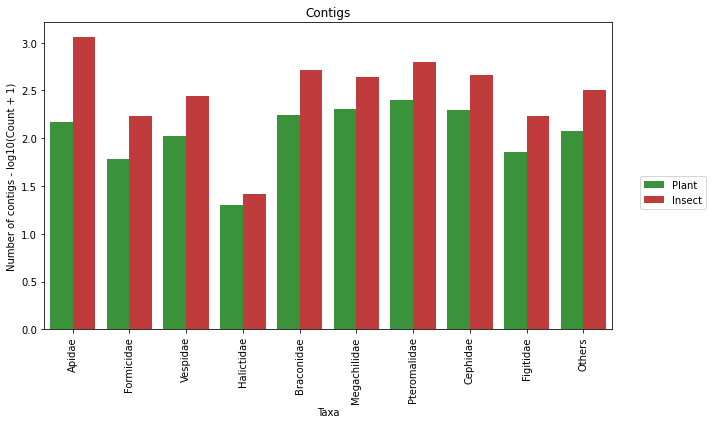

In [236]:
def retSum(df):
    return sum(df[df > 0.05].count() > (0.1 * len(df)))
    
Belgium_insectcov = submat(covmat_insect, Belgium_runs) 
Formicidae_insectcov = submat(covmat_insect, Formicidae_runs) 
Apidae_insectcov = submat(covmat_insect, Apidae_runs) 
Vespidae_insectcov = submat(covmat_insect, Vespidae_runs) 
Halictidae_insectcov = submat(covmat_insect, Halictidae_runs) 
Braconidae_insectcov = submat(covmat_insect, Braconidae_runs) 
Megachilidae_insectcov = submat(covmat_insect, Megachilidae_runs) 
Pteromalidae_insectcov = submat(covmat_insect, Pteromalidae_runs) 
Cephidae_insectcov = submat(covmat_insect, Cephidae_runs) 
Figitidae_insectcov = submat(covmat_insect, Figitidae_runs) 
Others_insectcov = submat(covmat_insect, Others_runs) 


dfLis = []
dfLis.append( ['Apidae', "Plant", retSum(Belgium_plantcov) + retSum(Apidae_plantcov) ] )
dfLis.append( ['Apidae', "Insect", retSum(Belgium_insectcov) + retSum(Apidae_insectcov) ] )
dfLis.append( ['Formicidae', "Plant", retSum(Formicidae_plantcov) ] )
dfLis.append( ['Formicidae', "Insect", retSum(Formicidae_insectcov) ] )
dfLis.append( ['Vespidae', "Plant", retSum(Vespidae_plantcov) ] )
dfLis.append( ['Vespidae', "Insect", retSum(Vespidae_insectcov) ] )
dfLis.append( ['Halictidae', "Plant", retSum(Halictidae_plantcov) ] )
dfLis.append( ['Halictidae', "Insect", retSum(Halictidae_insectcov) ] )
dfLis.append( ['Braconidae', "Plant", retSum(Braconidae_plantcov) ] )
dfLis.append( ['Braconidae', "Insect", retSum(Braconidae_insectcov) ] )
dfLis.append( ['Megachilidae', "Plant", retSum(Megachilidae_plantcov) ] )
dfLis.append( ['Megachilidae', "Insect", retSum(Megachilidae_insectcov) ] )
dfLis.append( ['Pteromalidae', "Plant", retSum(Pteromalidae_plantcov) ] )
dfLis.append( ['Pteromalidae', "Insect", retSum(Pteromalidae_insectcov) ] )
dfLis.append( ['Cephidae',"Plant", retSum(Cephidae_plantcov) ] )
dfLis.append( ['Cephidae',"Insect", retSum(Cephidae_insectcov) ] )
dfLis.append( ['Figitidae', "Plant", retSum(Figitidae_plantcov) ] )
dfLis.append( ['Figitidae', "Insect", retSum(Figitidae_insectcov) ] )
dfLis.append( ['Others', 'Plant', retSum(Others_plantcov) ] )
dfLis.append( ['Others', 'Insect', retSum(Others_insectcov) ] )

df = pd.DataFrame(dfLis)
df.columns = [ 'Taxa', 'Status', 'Count' ]
df['logCount'] = np.log10(df['Count'] + 1)
plt.figure(figsize=(10, 6) )

taxCols = [
    '#d62727', #Apidae, red
    '#1f77b4', #Formicidae, blue
    '#ff7f0e', #Vespidae, orange
    '#2ca02c', #Halictidae, green
    '#9467bd', #Braconidae, purple
    '#8c564b', #Megachilidae, brown
    '#e377c2', #Pteromalidae, pink
    '#7f7f7f', #Cephidae, gray
    '#bcbd22', #Figitidae, yellow
    '#17becf', #Others, lightlue
]

g = sns.barplot(data=df, x='Taxa', y='logCount', hue='Status', palette=['#2ca02c', '#d62525'])
g.tick_params(axis='x', rotation=90)
g.set_ylabel("Number of contigs - log10(Count + 1)")
g.set_title("Contigs")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
plt.tight_layout()
g.figure.savefig("../Figures/countPlot_hymen_plantInsect.svg", dpi=300)

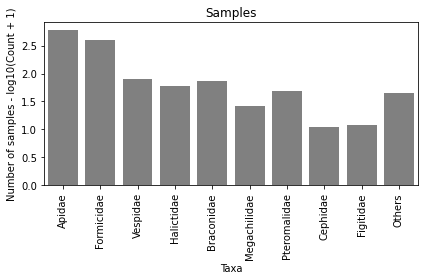

In [238]:
# Plot number of samples per lineage.
dfLis = []
dfLis.append( ['Apidae', len(Apidae_runs) ] )
dfLis.append( ['Formicidae', len(Formicidae_runs) ] )
dfLis.append( ['Vespidae', len(Vespidae_runs) ] )
dfLis.append( ['Halictidae', len(Halictidae_runs) ] )
dfLis.append( ['Braconidae', len(Braconidae_runs) ] )
dfLis.append( ['Megachilidae', len(Megachilidae_runs) ] )
dfLis.append( ['Pteromalidae', len(Pteromalidae_runs) ] )
dfLis.append( ['Cephidae', len(Cephidae_runs) ] )
dfLis.append( ['Figitidae', len(Figitidae_runs) ] )
dfLis.append( ['Others', len(Others_runs) ] )

df = pd.DataFrame(dfLis)
df.columns = [ 'Taxa', 'Count' ]
df['logCount'] = np.log10(df['Count'] + 1)
g = sns.barplot(data=df, x='Taxa', y='logCount', color='gray')
g.tick_params(axis='x', rotation=90)
g.set_title("Samples")
g.set_ylabel("Number of samples - log10(Count + 1)")
plt.tight_layout()
g.figure.savefig("../Figures/countPlot_hymen_Samples.svg", dpi=300)

In [211]:
#now evaluate presence (defined as a relative count > 0.1 (assuming average of 100bp reads, this would be 10x covered, and the average is actually ~189))
#This treshold needs to be true for 10% of the samples of a particular family, and then it's appended.

# Combine the contigs.

# Insect specific.

Combinations = ['Apidae','Formicidae','Vespidae','Halictidae','Braconidae','Megachilidae','Pteromalidae','Cephidae','Figitidae','Others']
Apidae2_insectcov = pd.concat([Belgium_insectcov, Apidae_insectcov])

insectDic = {
    'Apidae' : Apidae2_insectcov,
    'Formicidae' :Formicidae_insectcov,
    'Vespidae' : Vespidae_insectcov,
    'Halictidae' : Halictidae_insectcov,
    'Braconidae': Braconidae_insectcov,
    'Megachilidae': Megachilidae_insectcov,
    'Pteromalidae': Pteromalidae_insectcov,
    'Cephidae': Cephidae_insectcov,
    'Figitidae': Figitidae_insectcov,
    'Others' : Others_insectcov
}

insectContigs = Belgium_contigs_insect + \
                Formicidae_contigs_insect + \
                Apidae_contigs_insect + \
                Vespidae_contigs_insect + \
                Halictidae_contigs_insect + \
                Braconidae_contigs_insect + \
                Megachilidae_contigs_insect + \
                Pteromalidae_contigs_insect + \
                Cephidae_contigs_insect + \
                Figitidae_contigs_insect + \
                Others_contigs_insect
resDic = {}
insectLis = []
for comb in list(itertools.combinations(Combinations, 2)):
    df1 = insectDic[comb[0]]
    df2 = insectDic[comb[1]]
    
    df1Ret = df1[df1 > 0.05].count() > (0.1 * len(df1))
    df1_contigs = list(df1Ret[df1Ret != False].index)
    df2Ret = df2[df2 > 0.05].count() > (0.1 * len(df2))
    df2_contigs = list(df2Ret[df2Ret != False].index)
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    insectLis.append( [comb[0], comb[1], SharedC, len(set(df1_contigs + df2_contigs)) ] )
resDic['Insect'] = insectLis
resDic

# Random subsets.
Apidae2_plantcov = pd.concat([Belgium_plantcov, Apidae_plantcov])
plantDic = {
    'Apidae' : Apidae2_plantcov,
    'Formicidae' :Formicidae_plantcov,
    'Vespidae' : Vespidae_plantcov,
    'Halictidae' : Halictidae_plantcov,
    'Braconidae': Braconidae_plantcov,
    'Megachilidae': Megachilidae_plantcov,
    'Pteromalidae': Pteromalidae_plantcov,
    'Cephidae': Cephidae_plantcov,
    'Figitidae': Figitidae_plantcov,
    'Others' : Others_plantcov
}

plantContigs = Belgium_contigs_plant + \
                Formicidae_contigs_plant + \
                Apidae_contigs_plant + \
                Vespidae_contigs_plant + \
                Halictidae_contigs_plant + \
                Braconidae_contigs_plant + \
                Megachilidae_contigs_plant + \
                Pteromalidae_contigs_plant + \
                Cephidae_contigs_plant + \
                Figitidae_contigs_plant + \
                Others_contigs_plant
plantLis = []
for comb in list(itertools.combinations(Combinations, 2)):
    df1 = plantDic[comb[0]]
    df2 = plantDic[comb[1]]
    
    df1Ret = df1[df1 > 0.05].count() > (0.1 * len(df1))
    df1_contigs = list(df1Ret[df1Ret != False].index)
    df2Ret = df2[df2 > 0.05].count() > (0.1 * len(df2))
    df2_contigs = list(df2Ret[df2Ret != False].index)
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    plantLis.append( [comb[0], comb[1], SharedC, len(set(df1_contigs + df2_contigs))] )
resDic['Plant'] = plantLis

# Def 
def conf(set1, n1, set2, n2, thres = 0.05):
    p1 = set1/n1
    p2 = set2/n2
    var = p1 * (1-p1) / n1 + p2 * (1-p2)/n2
    se = np.sqrt(var)

    # z critical value
    conf = 1 - thres
    z = stats.norm(loc = 0, scale = 1).ppf(conf + thres / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    diff = p1 - p2
    confint = diff + np.array([-1, 1]) * z * se
    return diff, confint

nesres = []
# Combine the dictionary with subtractions.
for i,j in zip( resDic["Insect"], resDic['Plant'] ):
    if i[0] != j[0]:
        print("MisMatch")
    elif i[1] != j[1]:
        print("MisMatch")
    else:
        nesres.append([ i[0], i[1], conf(i[2], i[3], j[2], j[3])[0], conf(i[2], i[3], j[2], j[3])[1][0], conf(i[2], i[3], j[2], j[3])[1][1]  ])
#Write to file, and process in cytoscape
with open('../networks/Hymenoptera.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(nesres)

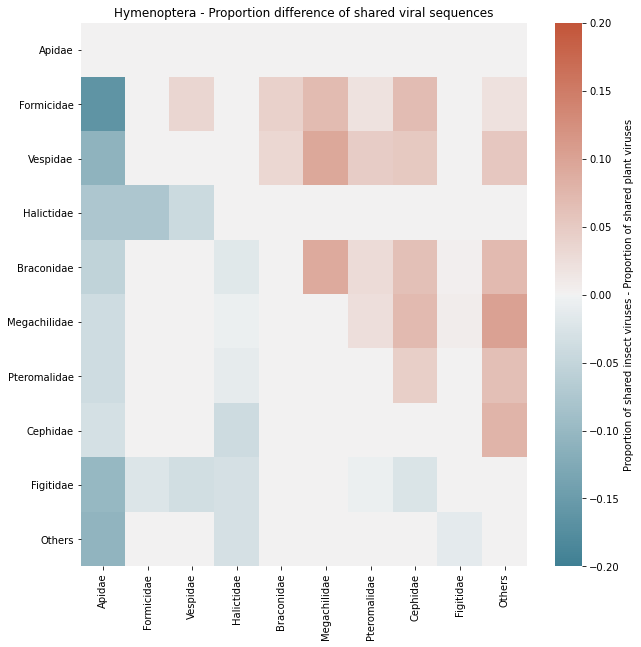

In [212]:
# Plot heatmap
xDic = {}
xCount = 0
for i in nesres:
    if i[0] not in xDic:
        xDic[i[0]] = xCount
        xCount += 1
xDic['Others'] = 9
# Create the data structure
mat = np.zeros( (10,10) )
# [['Apidae',
#   'Formicidae',
#   -0.16324237560192614,
#   -0.24500955402348434,
#   -0.08147519718036796]
 
for i in nesres:
    if i[2] > 0:
        xCor = xDic[i[0]]
        yCor = xDic[i[1]]
    else:
        xCor = xDic[i[1]]
        yCor = xDic[i[0]]
    mat[xCor, yCor] = i[2]

matDF = pd.DataFrame(mat)
matDF.columns = list(xDic.keys())
matDF.index = list(xDic.keys())
plt.figure(figsize=(10,10))
g = sns.heatmap(matDF, cmap=sns.diverging_palette(220, 20, as_cmap=True), center=0, vmin=-0.2, vmax=0.2, cbar_kws={'label': 'Proportion of shared insect viruses - Proportion of shared plant viruses'})
g.set_title("Hymenoptera - Proportion difference of shared viral sequences")
g.figure.savefig("../Figures/Hymen_sharing_heat.png", dpi=300)

In [205]:
################### Now look inside 'Apidae' lineage.###################
#Runs: Belgium_runs (Apis Melifera), and Apidae Runs (all Apidae).
#Contigs: Belgium_contigs, Apidae_contigs
#coverage matrix: covmat.

metadatdf[metadatdf['Run'].isin(Apidae_runs)]['ScientificName'].unique()
Apidae_groups= {'Apis Mellifera':['Apis mellifera intermissa','Apis mellifera','Apis mellifera ligustica','Apis mellifera carnica','Apis mellifera mellifera','Apis mellifera scutellata','Apis mellifera capensis','Apis mellifera syriaca'], 
                'Ceratina':['Ceratina australensis','Ceratina calcarata'],
                'Tetragonula':['Tetragonula carbonaria'],
                'Bombus':['Bombus cryptarum','Bombus pyrosoma','Bombus terrestris','Bombus terrestris audax'],
                'Apis cerana': ['Apis cerana','Apis cerana cerana'],
                'Euglossa':['Euglossa flammea','Euglossa dilemma'],
                'Eulaema':['Eulaema bombiformis','Eulaema meriana'],
                'Eucera':['Eucera nigrescens','Eucera nigriceps','Eucera sp. ''Tetraloniella'' AD-2014'],
                'Apis florea':['Apis florea'],
                'Lepidotrigona':['Lepidotrigona ventralis']
               }

ApisMellifera_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis Mellifera'])]['Run']) + Belgium_runs
Ceratina_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Ceratina'])]['Run'])
Tetragonula_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Tetragonula'])]['Run'])
Bombus_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Bombus'])]['Run'])
ApisCerana_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis cerana'])]['Run'])
Euglossa_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Euglossa'])]['Run'])
Eulaema_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Eulaema'])]['Run'])
Eucera_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Eucera'])]['Run'])
ApisFlorea_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis florea'])]['Run'])
Lepidotrigona_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Lepidotrigona'])]['Run'])

Mellifera_plantcov = covmat_plant[covmat_plant.index.isin(ApisMellifera_Runs)]
Ceratina_plantcov = covmat_plant[covmat_plant.index.isin(Ceratina_Runs)]
Tetragonula_plantcov = covmat_plant[covmat_plant.index.isin(Tetragonula_Runs)]
Bombus_plantcov = covmat_plant[covmat_plant.index.isin(Bombus_Runs)]
ApisCerana_plantcov = covmat_plant[covmat_plant.index.isin(ApisCerana_Runs)]
Euglossa_plantcov = covmat_plant[covmat_plant.index.isin(Euglossa_Runs)]
Eulaema_plantcov = covmat_plant[covmat_plant.index.isin(Eulaema_Runs)]
Eucera_plantcov = covmat_plant[covmat_plant.index.isin(Eucera_Runs)]
ApisFlorea_plantcov = covmat_plant[covmat_plant.index.isin(ApisFlorea_Runs)]
Lepidotrigona_plantcov = covmat_plant[covmat_plant.index.isin(Lepidotrigona_Runs)]

Mellifera_insectcov = covmat_insect[covmat_insect.index.isin(ApisMellifera_Runs)]
Ceratina_insectcov = covmat_insect[covmat_insect.index.isin(Ceratina_Runs)]
Tetragonula_insectcov = covmat_insect[covmat_insect.index.isin(Tetragonula_Runs)]
Bombus_insectcov = covmat_insect[covmat_insect.index.isin(Bombus_Runs)]
ApisCerana_insectcov = covmat_insect[covmat_insect.index.isin(ApisCerana_Runs)]
Euglossa_insectcov = covmat_insect[covmat_insect.index.isin(Euglossa_Runs)]
Eulaema_insectcov = covmat_insect[covmat_insect.index.isin(Eulaema_Runs)]
Eucera_insectcov = covmat_insect[covmat_insect.index.isin(Eucera_Runs)]
ApisFlorea_insectcov = covmat_insect[covmat_insect.index.isin(ApisFlorea_Runs)]
Lepidotrigona_insectcov = covmat_insect[covmat_insect.index.isin(Lepidotrigona_Runs)]

insectDic = {
    'Mellifera' : Mellifera_insectcov,
    'Ceratina' : Ceratina_insectcov,
    'Tetragonula' : Tetragonula_insectcov,
    'Bombus' : Bombus_insectcov,
    'ApisCerana' : ApisCerana_insectcov,
    'Euglossa' : Euglossa_insectcov,
    'Eulaema' : Eulaema_insectcov,
    'Eucera' : Eucera_insectcov,
    'ApisFlorea' : ApisFlorea_insectcov,
    'Lepidotrigona' : Lepidotrigona_insectcov
}


insectContigs = Belgium_contigs_insect + \
                Apidae_contigs_insect
resDic = {}
insectLis = []
for comb in list(itertools.combinations(list( insectDic.keys() ), 2)):
    df1 = insectDic[comb[0]]
    df2 = insectDic[comb[1]]
    
    df1Ret = df1[df1 > 0.05].count() > (0.1 * len(df1))
    df1_contigs = list(df1Ret[df1Ret != False].index)
    df2Ret = df2[df2 > 0.05].count() > (0.1 * len(df2))
    df2_contigs = list(df2Ret[df2Ret != False].index)
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    insectLis.append( [comb[0], comb[1], SharedC, len(set(df1_contigs + df2_contigs)) ] )
resDic['Insect'] = insectLis

plantDic = {
    'Mellifera' : Mellifera_plantcov,
    'Ceratina' : Ceratina_plantcov,
    'Tetragonula' : Tetragonula_plantcov,
    'Bombus' : Bombus_plantcov,
    'ApisCerana' : ApisCerana_plantcov,
    'Euglossa' : Euglossa_plantcov,
    'Eulaema' : Eulaema_plantcov,
    'Eucera' : Eucera_plantcov,
    'ApisFlorea' : ApisFlorea_plantcov,
    'Lepidotrigona' : Lepidotrigona_plantcov
}

plantContigs = Belgium_contigs_plant + \
                Apidae_contigs_plant

plantLis = []
for comb in list(itertools.combinations(list( plantDic.keys() ), 2)):
    df1 = plantDic[comb[0]]
    df2 = plantDic[comb[1]]
    
    df1Ret = df1[df1 > 0.05].count() > (0.1 * len(df1))
    df1_contigs = list(df1Ret[df1Ret != False].index)
    df2Ret = df2[df2 > 0.05].count() > (0.1 * len(df2))
    df2_contigs = list(df2Ret[df2Ret != False].index)
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    plantLis.append( [comb[0], comb[1], SharedC, len(set(df1_contigs + df2_contigs)) ] )
resDic['Plant'] = plantLis

nesres = []
# Combine the dictionary with subtractions.
for i,j in zip( resDic["Insect"], resDic['Plant'] ):
    if i[0] != j[0]:
        print("MisMatch")
    elif i[1] != j[1]:
        print("MisMatch")
    else:
        nesres.append([ i[0], i[1], conf(i[2], i[3], j[2], j[3])[0], conf(i[2], i[3], j[2], j[3])[1][0], conf(i[2], i[3], j[2], j[3])[1][1]  ])
#Write to file, and process in cytoscape
with open('../networks/Apidae.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(nesres)

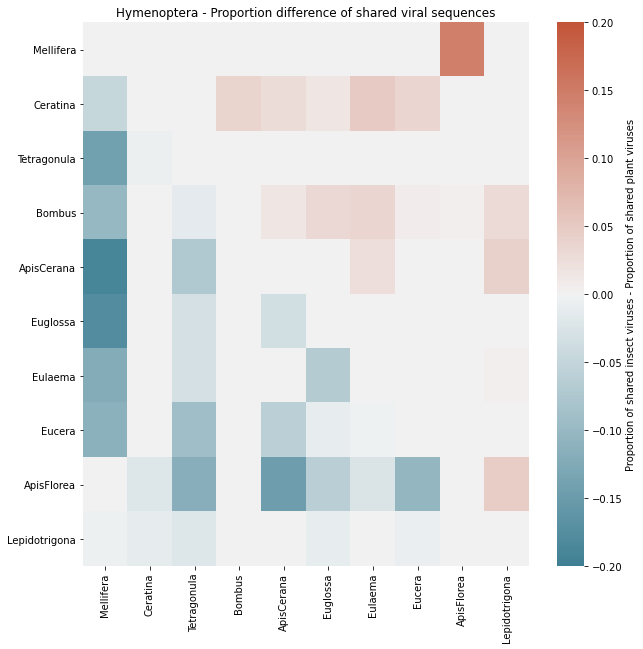

In [210]:
# Plot heatmap
xDic = {}
xCount = 0
for i in nesres:
    if i[0] not in xDic:
        xDic[i[0]] = xCount
        xCount += 1

xDic['Lepidotrigona'] = 9
# Create the data structure
mat = np.zeros( (10,10) )

 
for i in nesres:
    if i[2] > 0:
        xCor = xDic[i[0]]
        yCor = xDic[i[1]]
    else:
        xCor = xDic[i[1]]
        yCor = xDic[i[0]]
    mat[xCor, yCor] = i[2]


matDF = pd.DataFrame(mat)
matDF.columns = list(xDic.keys())
matDF.index = list(xDic.keys())
plt.figure(figsize=(10,10))
g = sns.heatmap(matDF, cmap=sns.diverging_palette(220, 20, as_cmap=True), center=0, vmin=-0.2, vmax=0.2, cbar_kws={'label': 'Proportion of shared insect viruses - Proportion of shared plant viruses'})

g.set_title("Hymenoptera - Proportion difference of shared viral sequences")
g.figure.savefig("../Figures/Apid_sharing_heat.png", dpi=300)